In [1]:
import openpyxl
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import svm
import datetime
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

import statsmodels.api as sm

import itertools
import optuna

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima_model
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
wb1 = openpyxl.load_workbook(r"data_sheets\Книга1.xlsx")
sheet = wb1['Лист4']

In [3]:
def df_test(frame_col):
    print('Результат теста:')
    df_result = adfuller(frame_col)
    df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for result_value, label in zip(df_result, df_labels):
        print(label + ' : ' + str(result_value))

    if df_result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
        return True
    else:
        print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")
        return False

100 100


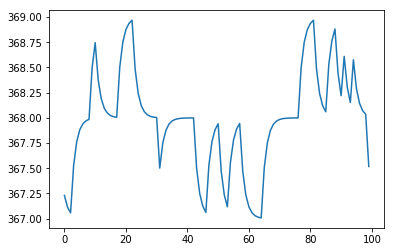

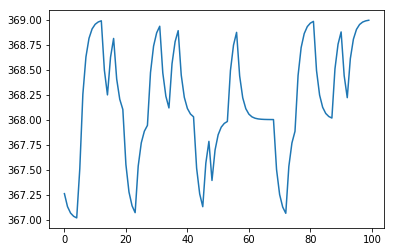

In [6]:
start = datetime.datetime.now()
timer_train = []
timer_test = []
batch_train = []
batch_test = []
n = 4000
border = 4100
num = 4200
for i in range (0, border-n):
    timer_train.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_train.append(float(sheet.cell(row = i+n, column = 2).value))
for j in range (border-n, num-n):
    timer_test.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_test.append(float(sheet.cell(row = j+n, column = 2).value))
print(len(batch_train), len(batch_test))
plt.plot(batch_train)
plt.show()
plt.plot(batch_test)
plt.show()

    

Результат теста:
ADF Test Statistic : -5.877042095927208
p-value : 3.1417076161622136e-07
#Lags Used : 4
Number of Observations Used : 94
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


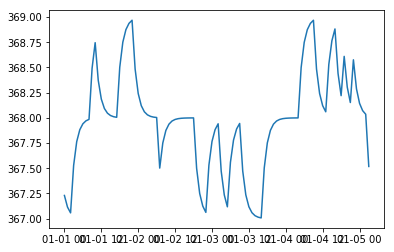

In [8]:
df1 =  pd.DataFrame(columns = ["flow1", "time"])
df1.time = timer_train
df1.flow1 = batch_train
df1_diff = df1.diff().dropna()
while(df_test(df1_diff['flow1']) != True):
    df1_diff = df1_diff.diff().dropna()
df1.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df1['flow1']), freq='h')
df1_diff.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df1_diff['flow1']), freq='h')
plt.plot(df1['flow1'])

Результат теста:
ADF Test Statistic : -4.041020178812329
p-value : 0.001210311046683184
#Lags Used : 1
Number of Observations Used : 98
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


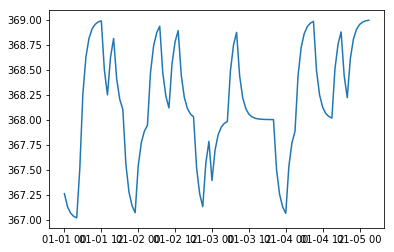

In [10]:
df2 =  pd.DataFrame(columns = ["flow1", "time"])
df2.time = timer_test
df2.flow1 = batch_test
df2_diff = df2.diff().dropna()
while((df_test(df2['flow1']) != True) and (i in range (1, 10))):
    df2_diff = df2_diff.diff().dropna()
df2.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df2['flow1']), freq='h')
df2_diff.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df2_diff['flow1']), freq='h')
plt.plot(df2['flow1'])

In [153]:
model1 = SARIMAX(df1_diff['flow1'],exog = df2_diff["flow1"], order=(4, 1, 4), seasonal_order=(4, 0, 4, 5), trend = 'c', enforce_invertibility = False)
result1 = model1.fit()

prog_start = 0

pred1 = result1.get_prediction(start = prog_start, dynamic = False)
forecast_values1 = pred1.predicted_mean

In [154]:
difference = np.mean(forecast_values1 - df2_diff['flow1'])
forecast_mse1 = np.sqrt(((forecast_values1 - df2_diff['flow1']) ** 2).mean())
print(forecast_mse1, difference)

0.2720015372407954 -0.007546516235986901


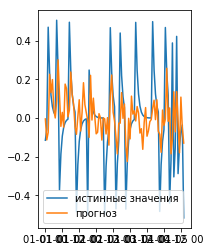

In [155]:
#forecast_mse1 = ((forecast_values1 - batch_test) ** 2).mean()
plt.plot(df1['flow1'])    
figure = pylab.subplot(1,2,2)
figure1 = pylab.plot(df1_diff['flow1'], label = "истинные значения")
figure2 = pylab.plot(forecast_values1, label = "прогноз")
pylab.legend()

In [31]:
def params_optimization(dataset, dataset_test, seasonal, non_seasonal, cycles):
    optimal_params_arr = []
    optimal_seasonal_params_arr = []
    mse_temp = 100
    delta_temp = 10
    print("ARIMA variation")
    for i in range(1, 5):
        for j in range(0, 6):
            for k in range(1, 5):
                non_seasonal = [i, j, k]
                try:
                    model1 = SARIMAX(dataset, exog = dataset_test, order=non_seasonal, seasonal_order=seasonal)
                    result1 = model1.fit(disp = False)
                except:
                    continue
                pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = df2['flow1'])
                forecast_values1 = pred1.predicted_mean
                difference = np.mean(forecast_values1 - dataset_test)
                forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
                if (forecast_mse_temp < mse_temp):
                    optimal_params_arr = [i, j, k]
                    mse_temp = forecast_mse_temp
    print(optimal_params_arr)
    print("number of seasons")
    for i in range (1, cycles):
        seasonal[3] = i
        try:
            model1 = SARIMAX(dataset, exog = dataset_test, order=optimal_params_arr, seasonal_order=seasonal)
            result1 = model1.fit(disp = False)
        except:
            continue
        pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = dataset_test)
        forecast_values1 = pred1.predicted_mean
        difference = np.mean(forecast_values1 - dataset_test)
        forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
        if (forecast_mse_temp < mse_temp):
            optimal_seasonal_params_arr = [1, 1, 1, i]
            mse_temp = forecast_mse_temp
        #print(seasonal, difference, forecast_mse_temp)
    seasons_optimal = optimal_seasonal_params_arr[3]
    print(seasons_optimal)
    print("seasomal parameters")
    
    for i in range(1, 5):
        for j in range(0, 6):
            for k in range(1, 5):
                seasonal = [i, j, k, seasons_optimal]
                try:
                    model1 = SARIMAX(dataset, exog = dataset_test, order=optimal_params_arr, seasonal_order=seasonal)
                    result1 = model1.fit(disp = False)
                    print(optimal_params_arr, seasonal)
                except:
                    continue
                pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = df2['flow1'])
                forecast_values1 = pred1.predicted_mean
                difference = np.mean(forecast_values1 - dataset_test)
                forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
                
                if (forecast_mse_temp < mse_temp):
                    optimal_seasonal_params_arr = seasonal
                    mse_temp = forecast_mse_temp
    return [optimal_params_arr, optimal_seasonal_params_arr, mse_temp]

In [82]:
params_non_seasonal = [1, 0, 1]
params_seasonal = [1, 0, 1, 10]
#print(params_optimization(df1_diff["flow1"], df2_diff['flow1'], params_seasonal, params_non_seasonal, 27))


In [142]:
batch_test = df1_diff['flow1']
batch_train = df2_diff['flow1']

p1 = range(1, 5)
d1 = range(0, 6)
q1 = range(1, 5)
    
ps = range(1, 5)
ds = range(0, 6)
qs = range(1, 5)
s = 5
    
pdq = list(itertools.product(p1, d1, q1))
pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(ps, ds, qs))]
    
def optuna_objective(trial):
    non_seasonal_trial = trial.suggest_categorical('non_seasonal_order', pdq)
    seasonal_trial = trial.suggest_categorical('seasonal_order', pdqs)
    trend = trial.suggest_categorical('trend', ['n', 'c', 't', 'ct', None])
    try:
        model_trial = SARIMAX(batch_train, exog = batch_test, order=non_seasonal_trial, seasonal_order=seasonal_trial)
        result = model_trial.fit(disp = True)
    except:
        return float('inf')
    prediction = result.get_prediction(start = prog_start, dynamic = False, exog = batch_test)
    forecast_values = prediction.predicted_mean
    mse = np.sqrt(((forecast_values - batch_test) ** 2).mean())
    return mse
    
study = optuna.create_study(direction = "minimize")
print(study.optimize(optuna_objective, n_trials = 12))
    

[I 2024-10-23 14:58:51,248] A new study created in memory with name: no-name-a82350ea-411a-4545-a147-524ab9c744a8
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-package

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 2, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 5, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 0, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 0, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 1, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 1, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 1, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 2, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 3, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 3, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 4, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 4, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 4, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 5, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 5, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 0, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 1, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 1, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 1, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 5, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 5, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 0, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 4, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 4, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 5, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 5, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 5, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 0, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 2, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 2, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 2, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 3, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 5, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 5, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 5, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 0, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 0, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 1, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 2, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 2, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 2, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 4, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 5, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 5, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 5, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 0, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 0, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 1, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 3, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 3, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 3, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 4, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 5, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 5, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 5, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 5, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 0, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 0, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 0, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 1, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 1, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 2, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 3, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 3, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 3, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 4, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 4, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 5, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 0, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 0, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 0, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 1, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 1, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 2, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 5, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 0, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 0, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 3, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 3, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 4, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 4, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 4, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 5, 4, 5) which is of type tuple.
  warnings.warn(message)
[I 2024-10-23 14:59:03,699] Trial 6 finished with value: inf and parameters: {'non_seasonal_order': (1, 5, 4), 'seasonal_order': (3, 4, 1, 5), 'trend': 't'}. Best is trial 3 with value: 0.2403196317376955.
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 2) whi

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 2, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 2, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 5, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 5, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 0, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 1, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 1, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 1, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 2, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 2, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 3, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 4, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 4, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 5, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 5, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 5, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 0, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 1, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 1, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 3, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 5, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 5, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 5, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 4, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 5, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 5, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 5, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 0, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 0, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 2, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 2, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 2, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 3, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 3, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 4, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 5, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 5, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 0, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 0, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 0, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 1, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 2, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 2, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 5, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 5, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 0, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 0, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 0, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 3, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 3, 2) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 3, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 4, 3) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 4, 4) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 5, 1) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 1, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 2, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 3, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 4, 4, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 5, 1, 5) which is of type tuple.
  warnings.warn(message)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of N

None


In [156]:
difference = np.mean(forecast_values1 - df2_diff['flow1'])
forecast_mse1 = np.sqrt(((forecast_values1 - df2_diff['flow1']) ** 2).mean())
print(forecast_mse1, difference)

0.2720015372407954 -0.007546516235986901
